In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
spark = SparkSession.builder.appName("Wrangling Data").getOrCreate()

In [33]:
user_log_df = spark.read.json("sparkify_log_small.json")

In [34]:
user_log_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [35]:
user_log_df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

Describe a specific column

In [36]:
user_log_df.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|             8347|
|   mean|249.6486587492506|
| stddev|95.00437130781461|
|    min|          1.12281|
|    max|        1806.8371|
+-------+-----------------+



### Different manipulations

In [37]:
user_log_df.count()

10000

In [38]:
user_log_df.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [39]:
user_log_df.select(["userId", "firstname", "page", "song"]).where(user_log_df.userId == "1046").show()

+------+---------+--------+--------------------+
|userId|firstname|    page|                song|
+------+---------+--------+--------------------+
|  1046|  Kenneth|NextSong|Christmas Tears W...|
|  1046|  Kenneth|NextSong|  Be Wary Of A Woman|
|  1046|  Kenneth|NextSong|   Public Enemy No.1|
|  1046|  Kenneth|NextSong|Reign Of The Tyrants|
|  1046|  Kenneth|NextSong|      Father And Son|
|  1046|  Kenneth|NextSong|               No. 5|
|  1046|  Kenneth|NextSong|           Seventeen|
|  1046|  Kenneth|    Home|                NULL|
|  1046|  Kenneth|NextSong|          War on war|
|  1046|  Kenneth|NextSong|   Killermont Street|
|  1046|  Kenneth|NextSong|        Black & Blue|
|  1046|  Kenneth|  Logout|                NULL|
|  1046|  Kenneth|    Home|                NULL|
|  1046|  Kenneth|NextSong|     Heads Will Roll|
|  1046|  Kenneth|NextSong|Bleed It Out [Liv...|
|  1046|  Kenneth|NextSong|              Clocks|
|  1046|  Kenneth|NextSong|           Love Rain|
|  1046|  Kenneth|Ne

In [40]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour) # user defined function

user_log_df = user_log_df.withColumn("hour", get_hour(user_log_df.ts)) # create a new column "hour"
user_log_df.show(1)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|   1|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+----------

In [41]:
# "filter" is the same with "where" 
songs_in_hour_df = user_log_df.filter(user_log_df.page == "NextSong").groupby(user_log_df.hour).count().orderBy(user_log_df.hour.cast("float"))
songs_in_hour_df.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  248|
|   1|  369|
|   2|  375|
|   3|  456|
|   4|  454|
|   5|  382|
|   6|  302|
|   7|  352|
|   8|  276|
|   9|  348|
|  10|  358|
|  11|  375|
|  12|  249|
|  13|  216|
|  14|  228|
|  15|  251|
|  16|  339|
|  17|  462|
|  18|  479|
|  19|  484|
+----+-----+
only showing top 20 rows



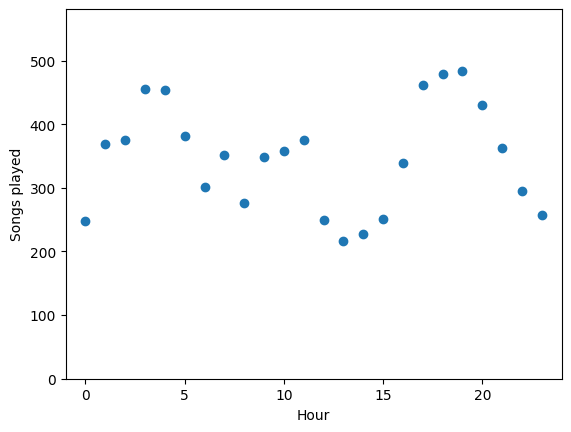

In [42]:
songs_in_hour_pd = songs_in_hour_df.toPandas() # pandas conversion
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.show()

In [43]:
user_log_valid_df = user_log_df.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid_df.count()

10000

In [44]:
user_log_valid_df = user_log_valid_df.filter(user_log_valid_df["userId"] != "")
user_log_valid_df.count()

9664

In [45]:
user_log_df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [46]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

user_log_valid_df = user_log_valid_df.withColumn("downgraded", flag_downgrade_event("page"))
user_log_valid_df.show(1)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|downgraded|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|   1|         0|
+-------------+---------+---------+------+-------------+--------+---------+-----+---

In [53]:
# window is an advanced version of "pandas groupby + apply". orderBy causes cumulativity!
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0) 

user_log_valid_df = user_log_valid_df.withColumn("phase", Fsum("downgraded").over(windowval))
user_log_valid_df.show()

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------+-----+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|downgraded|phase|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+----------+-----+
|  The Get Up Kids|Logged In| Veronica|     F|            0| Buckley|178.59873| free|Detroit-Warren-De...|   PUT|NextSong|1512966806284|     6676|             Overdue|   200|1513828388284|"Mozilla/5.0 (Mac...|    10|   6|         0|    0|
|      OneRepublic|Logged In| Veronica|     

In [54]:
user_log_valid_df.select(["userId", "firstname", "ts", "page", "level", "phase", "downgraded"]).where(user_log_df.userId == "1138").sort("ts").show(100)

+------+---------+-------------+----------------+-----+-----+----------+
|userId|firstname|           ts|            page|level|phase|downgraded|
+------+---------+-------------+----------------+-----+-----+----------+
|  1138|    Kelly|1513729066284|            Home| paid|    1|         0|
|  1138|    Kelly|1513729066284|        NextSong| paid|    1|         0|
|  1138|    Kelly|1513729313284|        NextSong| paid|    1|         0|
|  1138|    Kelly|1513729552284|        NextSong| paid|    1|         0|
|  1138|    Kelly|1513729783284|        NextSong| paid|    1|         0|
|  1138|    Kelly|1513730001284|        NextSong| paid|    1|         0|
|  1138|    Kelly|1513730263284|        NextSong| paid|    1|         0|
|  1138|    Kelly|1513730518284|        NextSong| paid|    1|         0|
|  1138|    Kelly|1513730768284|        NextSong| paid|    1|         0|
|  1138|    Kelly|1513731182284|        NextSong| paid|    1|         0|
|  1138|    Kelly|1513731435284|        NextSong| p